In [2]:
import datetime 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import seaborn as sns
%matplotlib inline

sns.set_style("white")

------------ 

# Data preparation

In [3]:
# read the data
cars = pd.read_csv("autos.csv", encoding="Latin1", parse_dates = ['dateCrawled','dateCreated','lastSeen'])

In [3]:
# clean the data:
# only these values make sense for car age:
cars = cars[(cars.yearOfRegistration < 2017) & (cars.yearOfRegistration > 1900)]
# we don't want to have non-sensible prices:
cars = cars[(cars.price < 500000) & (cars.price > 500)]
# only interested in working cars for now:
cars = cars[cars.notRepairedDamage != "ja"]

In [4]:
cars = cars.assign(mileage_cat=[("low", "medium", "med-high", "high")[min(3, int(math.floor(x/50000)))] for x in cars.kilometer])

In [5]:
# age is a better feature than year of registration
# here we use the number of days since registration
cars = cars.assign(age=[datetime.timedelta(seconds=(x.dateCreated.timestamp() - 
                        (datetime.datetime.strptime(
                            str(x.yearOfRegistration) + str(x.monthOfRegistration), "%Y%M")).timestamp())).days
                        for i, x in cars.iterrows()])

In [6]:
# only use cars not registered in the future
cars = cars[cars.age > 0]

In [7]:
# save the modified csv
cars.to_csv("autos.mod.csv")

In [4]:
# to start with cleaned & modified data:
cars = pd.read_csv("autos.mod.csv")

In [7]:
cars.offerType.value_counts()

Angebot    292692
Gesuch          3
Name: offerType, dtype: int64

(0, 50000)

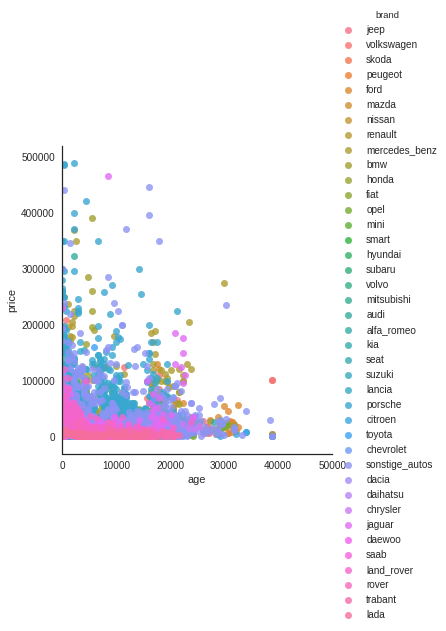

In [8]:
#cars.plot(x="yearOfRegistration", y="price", kind="scatter", ylim=(0, 1000000))
plt.figure()
sns.lmplot('age', 'price', data=cars, fit_reg=False, hue="brand")
plt.xlim(0, 50000)

In [9]:
# most common models
cars.model.value_counts()[:20]

golf           23435
andere         20893
3er            17214
polo            9131
a4              8674
passat          8482
corsa           8364
astra           8094
c_klasse        7784
5er             7485
e_klasse        6562
a3              5604
a6              5120
transporter     4720
focus           4708
fiesta          4011
2_reihe         4004
fortwo          3847
1er             3511
a_klasse        3483
Name: model, dtype: int64

In [10]:
# get general depreciation
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(cars.loc[:, ("kilometer", "yearOfRegistration")], y=cars.price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
clf.coef_

array([ -8.23876684e-02,   2.49589934e+02])

In [ ]:
# compare depreciation per model

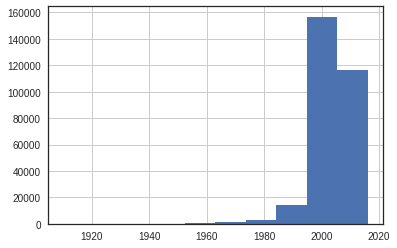

In [12]:
cars.yearOfRegistration.hist()

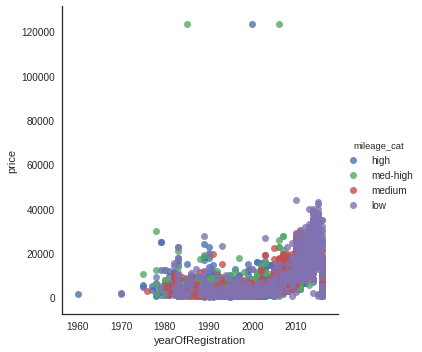

In [13]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="golf"], fit_reg=False, hue="mileage_cat")

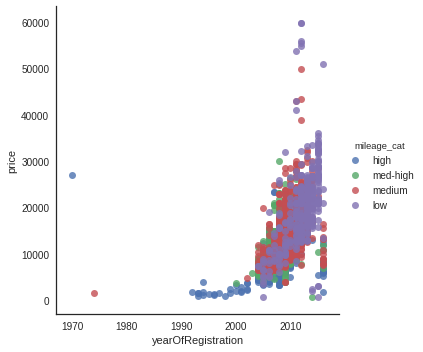

In [14]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="1er"], fit_reg=False, hue="mileage_cat")

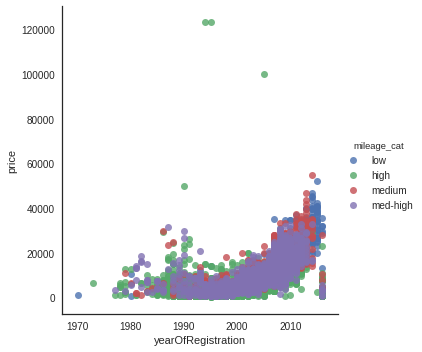

In [15]:
sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="3er"], fit_reg=False, hue="mileage_cat")

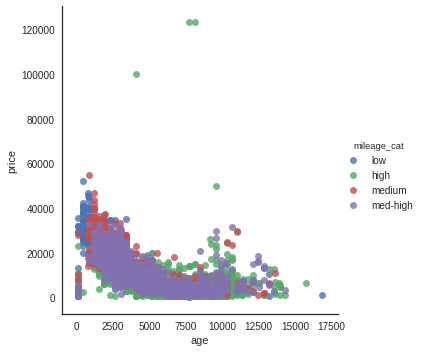

In [17]:
sns.lmplot('age', 'price', data=cars[cars.model=="3er"], fit_reg=False, hue="mileage_cat")

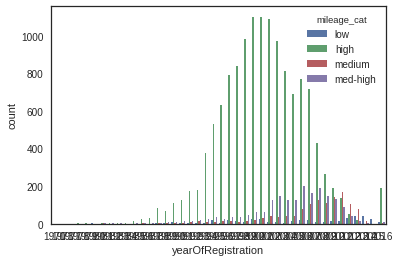

In [16]:
sns.countplot(x="yearOfRegistration", hue="mileage_cat", data=cars[cars.model=="3er"])

In [69]:
# write function for fit parameters for one model
# run function for all models > 100 entries
# test accuracy for each
# see how good my accuracy is, maybe also depending on input data

I predict a 3 year old Golf with 150 PS and 40k kilometers on the clock to cost ~ 16814.4368606
theta: [  5612.42592047   4724.69565644    406.07978748   1233.11401796
 -12369.64100737  -9168.16131655 -17497.54230074  10062.00343091
   6599.56280783  22702.58954584  -1261.06086217     91.61418816
  -8382.18396567]


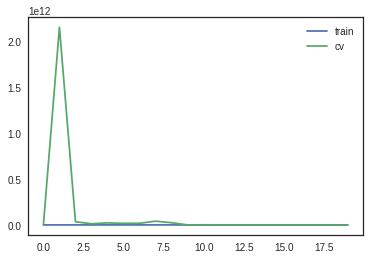

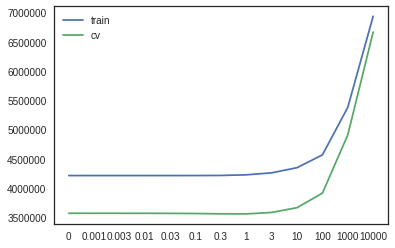

In [36]:
# try to fit model
import main
import importlib
importlib.reload(main)
main.fit_params(cars[cars.model=="golf"].loc[:, ("powerPS", "kilometer", "age")], cars.price[cars.model=="golf"])